<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [194]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [195]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [196]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [197]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [198]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [199]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + 1/C_s * dt * (F(t[i]) - gamma * (T[i] - theta[i]))
    theta[i+1] = theta[i] + 1/C_d * dt * gamma * (T[i] - theta[i])

After you are finished, run the cell below to plot the results

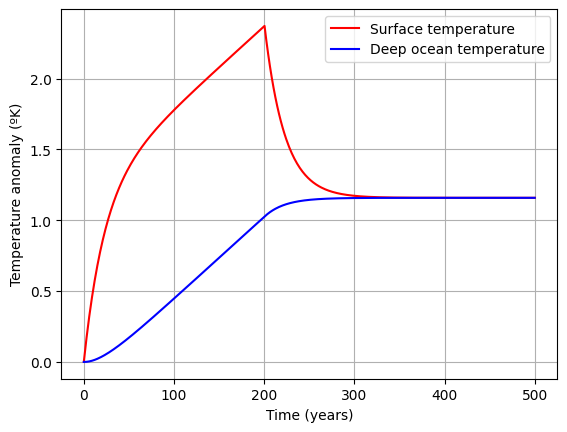

In [200]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.grid()
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

The temperature change can be split in three sections prior to reaching equilibrium.
1) At the start, the timescale of the ocean is $\frac{C_s}{\gamma}$, which is larger than timescale of surface ($\frac{C_d}{\gamma}$), so it takes longer for the ocean to heat up.
2) From about $t=75$, $T>>\theta$ and $\gamma \theta << 1$ so the important terms are $F=1$ and $\gamma T$. This implies that $C_s\frac{\partial T}{\partial t}\approx 1-\gamma T$ so $T\propto \frac{1}{C_s}t$, hence displaying almost linear increase until the forcing is turned off. ** check that the linear is actually dominant here**
3) No forcing: same timescales as before so surface decreases more quickly (exponential decay) than ocean increases until they reach the same temperature, at which point both derivatives are zero. It is also interesting to note that the timescale of the difference in temperatures is $\frac{C_s}{\gamma(C_d-C_s)}$, so they reach equilibrium ($T-\theta$ reaches zero) in this timescale. This timescale can be calculated from solving $\frac{d}{dt}(T-\theta)$.

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

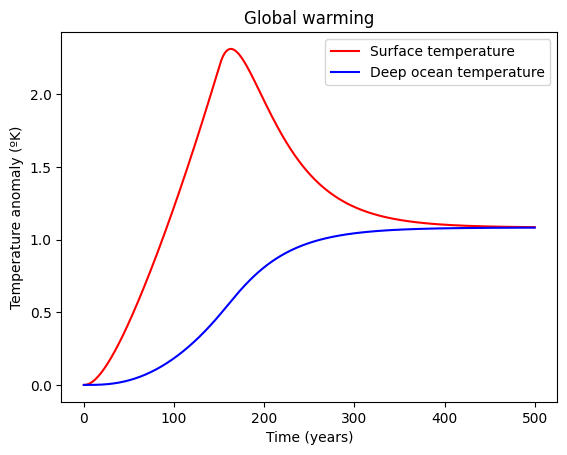

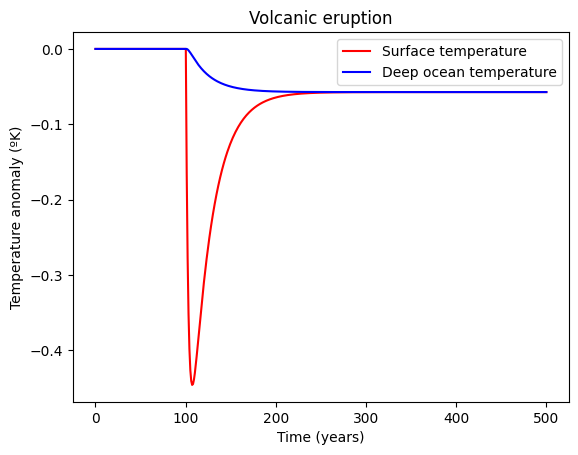

In [161]:
# Add code to make plots here
def plot_scenario(F, title):
  Nt = 500 # number of time steps (including the starting point)
  T = np.zeros(Nt) # surface temperature array
  theta = np.zeros(Nt) # deep ocean temperature array
  T[0] = 0 # initial surface temperature anomaly (ºK)
  theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

  t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
  dt = t[1] - t[0] # timestep in years
  for i in range(0, Nt-1):
    T[i+1] = T[i] + 1/C_s * dt * (F(t[i]) - gamma * (T[i] - theta[i]))
    theta[i+1] = theta[i] + 1/C_d * dt * gamma * (T[i] - theta[i])

  plt.plot(t,T,'r-')
  plt.plot(t,theta,'b-')
  plt.legend(['Surface temperature','Deep ocean temperature'])
  plt.xlabel('Time (years)')
  plt.ylabel('Temperature anomaly (ºK)')
  plt.title(title)
  plt.show()


def F1(t):
    return 0.01*t if t < 150 else 1.5*np.exp(-(t-150)/50) #global warming approaching a new equilibrium
title1 = 'Global warming'

def F2(t):
    return - 3 * np.exp(-(t-100)/3) if 100 < t  else 0 #volcanic eruption
title2 = 'Volcanic eruption'

plot_scenario(F1, title1)
plot_scenario(F2, title2)


Scenario 1: Global warming until we run out of fossil fuels or there are significant climate mitigation policies introduced at year 150 (hopefully this will happen sooner in real life!), reducing greenhouse emissions, so the earth's temperature goes back down, with a timescale of 50 years, but to a new equilibrium.

Scenario 2: volcanic eruption at t = 100 - causes cooling at timescale of 3 years. This represents the cooling from statospheric aerosols after an eruption


## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [162]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [163]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [164]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]


    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [165]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [177]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
print(x[1]-x[0])
print(t[1]-t[0])

0.02020202020202022
0.01001001001001001


Run each method once:

In [178]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.07 seconds


and finally, plot the results side-by-side

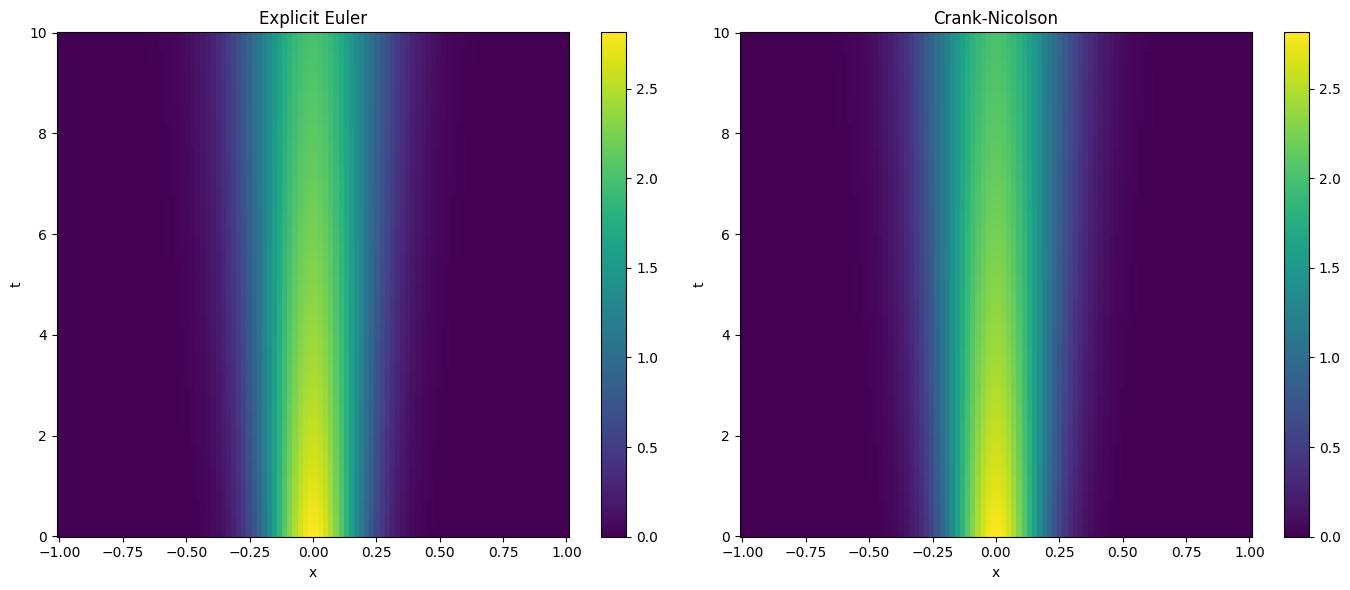

In [179]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

As $\kappa$ increases, we see the yellow region in the middle becomes larger in area, corresponding to a faster diffusion. This is expected as the true solution decays as $\kappa$ increases.

However, for large values of $\kappa>$, the explicit Euler scheme is produces concentrations tending to infinity. In particular, the code breaks down at approximately $\kappa=0.0311$, with the error message that the axis cannot be NaN or infty. This indicates instability in the solution.

We can perform Fourier stability analysis to the schemes to show that the Crank - Nicolson scheme is unconditionally stable, but Explicit Euler requires $$\frac{\kappa\delta t}{\delta x^2}<\frac{1}{2}.$$ For $\delta t \approx 0.01$ and $\delta x\approx 0.02$, we need $\kappa < 0.02$. This agrees with the results observed.



also look at varying dx and dt and perhaps save some of the plots.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

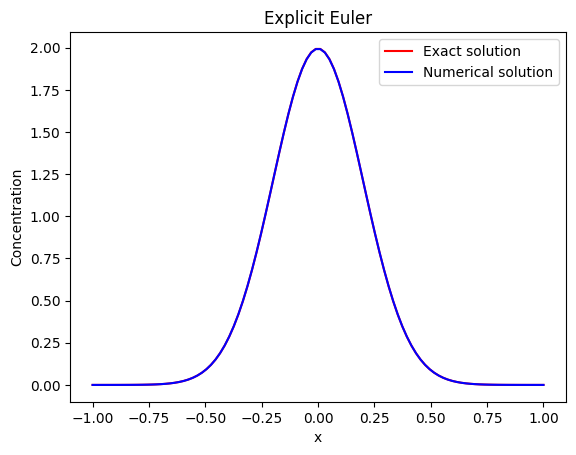

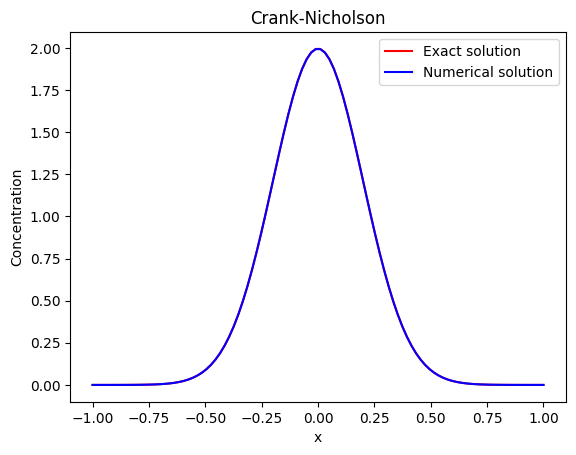

In [180]:
# Add code to plot exact and numerical solutions
t_ic = 10

def true_solution(x,t,z):
  return (1/(4*np.pi*z*(t+t_ic)))**(1/2)*np.exp(-(np.square(x))/(4*z*(t+t_ic)))

y = true_solution(x,10,kappa)


plt.plot(x,c_EE[:,999],'r-')
plt.plot(x,y,'b-')
plt.legend(['Exact solution','Numerical solution'])
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Explicit Euler')
plt.show()

plt.plot(x,c_CN[:,999],'r-')
plt.plot(x,y,'b-')
plt.legend(['Exact solution','Numerical solution'])
plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Crank-Nicholson')
plt.show()


The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

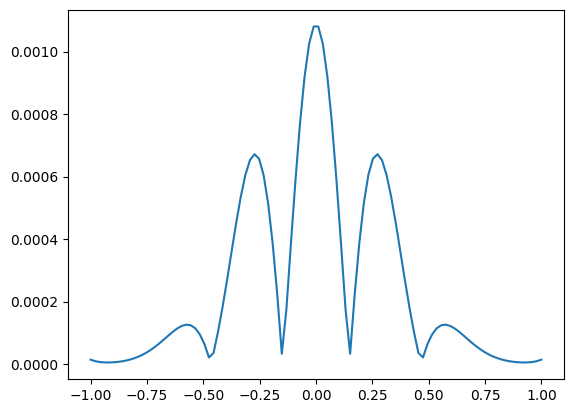

In [181]:
plt.plot(x,np.abs(y-c_EE[:,999]))

Crank-Nicolson method took 0.76 seconds
0.5
Crank-Nicolson method took 0.77 seconds
0.5
Crank-Nicolson method took 0.76 seconds
0.5
Crank-Nicolson method took 0.79 seconds
0.5
Crank-Nicolson method took 0.84 seconds
0.5
Crank-Nicolson method took 0.85 seconds
0.5
Crank-Nicolson method took 0.87 seconds
0.5
Crank-Nicolson method took 0.89 seconds
0.5
Crank-Nicolson method took 0.90 seconds
0.5
Crank-Nicolson method took 0.91 seconds
0.5
Crank-Nicolson method took 0.97 seconds
0.5
Crank-Nicolson method took 1.29 seconds
0.5
Crank-Nicolson method took 1.28 seconds
0.5
Crank-Nicolson method took 0.99 seconds
0.5
Crank-Nicolson method took 1.04 seconds
0.5
Crank-Nicolson method took 1.05 seconds
0.5
Crank-Nicolson method took 1.07 seconds
0.5
Crank-Nicolson method took 1.11 seconds
0.5
Crank-Nicolson method took 1.13 seconds
0.5
Crank-Nicolson method took 1.16 seconds
0.5


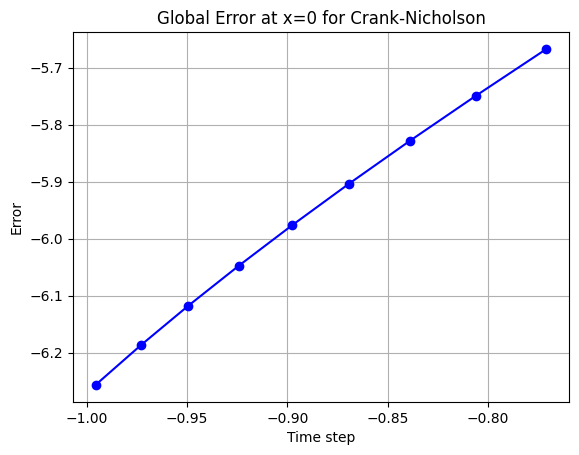

The gradient for the Crank-Nicolson log-log plot is [ 2.17881945 -4.01602282] .


In [182]:
# Add code to plot error here
# Changing the temporal step
kappa = 0.001
euler_error = np.zeros(20)
CN_error = np.zeros(20)
N = np.arange(10,110,5) # A range of number of steps to take to get to t=10
stepsize = np.divide(10,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nx = 1601

for i in range(20):
  Nt = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_CN = CN(x, t, kappa)
  arg = int(3/4*(Nx-1))
  print(x[arg])
  CN_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_CN[arg,-1])


plt.plot(np.log10(stepsize[10:19]), np.log10(CN_error[10:19]),'bo-')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.title('Global Error at x=0 for Crank-Nicholson')
plt.grid()
plt.show()
m_CN = np.polyfit(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]),1)
print('The gradient for the Crank-Nicolson log-log plot is',m_CN,'.')


In [193]:
# Add code to plot error here
# Changing the temporal step
kappa = 0.001
euler_error = np.zeros(10)
N = np.arange(45031,45041,1) # A range of number of steps to take to get to t=10
stepsize = np.divide(10,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nx = 3001

for i in range(10):
  Nt = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_EE = EE(x, t, kappa)
  arg = int(1/2*(Nx-1))
  euler_error[i] = np.abs(true_solution(0,t_end,kappa) - c_EE[arg,-1])



plt.plot(np.log10(stepsize[0:9]), np.log10(euler_error[0:9]), 'ro-')
plt.ylabel('Error')
plt.xlabel('Time step')
plt.title('Global Error at x=0 for Explicit Euler')
plt.grid()
plt.show()
m_EE = np.polyfit(np.log10(stepsize[0:9]), np.log10(euler_error[0:9]),1)
print('The gradient for the explicit Euler log-log plot is',m_EE,'.')

Explicit Euler method took 15.35 seconds
Explicit Euler method took 14.24 seconds
Explicit Euler method took 13.91 seconds
Explicit Euler method took 13.68 seconds
Explicit Euler method took 13.89 seconds
Explicit Euler method took 13.77 seconds
Explicit Euler method took 13.66 seconds
Explicit Euler method took 13.71 seconds


KeyboardInterrupt: 

Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.13 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.22 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.15 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.11 seconds


/tmp/ipython-input-3133503270.py:29: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(["Explicit Euler"],["Crank-Nicholson"])


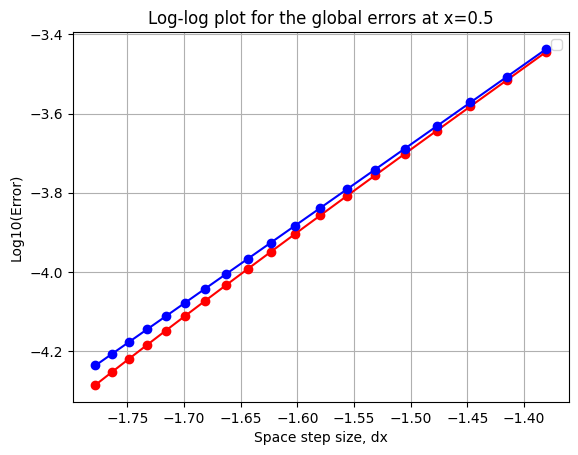

The gradient for the Euler log-log plot is [ 2.11457609 -0.52000148] .
The gradient for the Crank-Nicolson log-log plot is [ 2.01017121 -0.66282794] .


In [184]:
# Changing the spatial step
kappa = 0.001
euler_error = np.zeros(20)
CN_error = np.zeros(20)
N = np.arange(49,129,4)
stepsize = np.divide(2,N-1)

def true_solution(x,t,z):
  return (4*np.pi*z*(t+t_ic))**(-1/2)*np.exp((-x**2)/(4*z*(t+t_ic)))

t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
x_start = -1
x_end = 1
Nt = 2001

for i in range(20):
  Nx = N[i]
  t = np.linspace(t_start, t_end, Nt)
  x = np.linspace(x_start, x_end, Nx)
  c_EE = EE(x, t, kappa)
  c_CN = CN(x, t, kappa)
  arg = int(3/4*(Nx-1))
  euler_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_EE[arg,-1])
  CN_error[i] = np.abs(true_solution(0.5,t_end,kappa) - c_CN[arg,-1])

plt.plot(np.log10(stepsize[0:19]), np.log10(euler_error[0:19]), 'ro-')
plt.plot(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]), 'bo-')
plt.legend(["Explicit Euler"],["Crank-Nicholson"])
plt.ylabel('Log10(Error)')
plt.xlabel('Space step size, dx')
plt.title('Log-log plot for the global errors at x=0.5')
plt.grid()
plt.show()

m_EE = np.polyfit(np.log10(stepsize[0:19]), np.log10(euler_error[0:19]),1)
print('The gradient for the Euler log-log plot is',m_EE,'.')

m_CN = np.polyfit(np.log10(stepsize[0:19]), np.log10(CN_error[0:19]),1)
print('The gradient for the Crank-Nicolson log-log plot is',m_CN,'.')

It can be shown analytically that the Crank-Nicolson scheme is second order in space and time, whereas the Explicit Euler method is second order in space and first order in time.


The log-log plots of global error against step size agree with the theory for space steps for both schemes and time steps for Crank-Nicolson, as the gradients are all approximately 2. However, the log-log plot for the temporal error of the explicit Euler is giving a gradient of 1.5006.

This dicrepancy in gradient could be due to a few factors: influence of the spatial error, the application of BCs or application of ICs. To ensure that the temporal error is the dominant error, it is important that $\delta x^2<< \delta t$, without violating the stability conditions.
I managed to reduce the gradient from 1.8769 to 1.5006 by decreasing $\delta x$ significantly (from $\frac{2}{49}$ to $\frac{2}{3001}$) and using the 10 smallest values of $\delta t$ allowed, but decreasing it even further would take significant compution time.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

need to choose an error tolerance and use the error vs timestep graph from above (when it works properly!) to look at the speed of solutions at that error.

could plot error vs computation time plots and see when EE is better than CN and vice versa

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Text(0.5, 0, 'x')

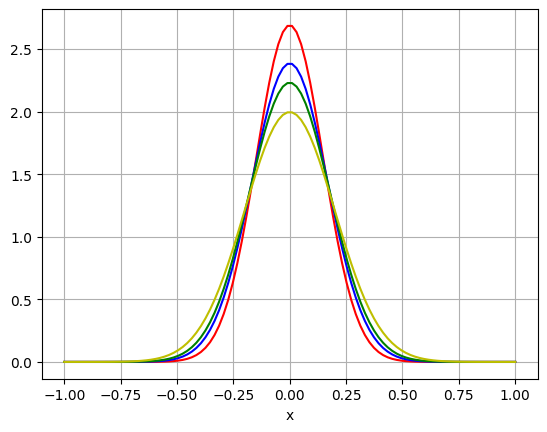

In [191]:
 def construct_M_BC(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    # Neumann BCs built in - need Mc[1,1]=Mc[-1,-1]=0
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M[0,1] = 2 #Setting the homogeneous Neumann boundary conditions into the matrix
        M[-1,-2]= 2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods


    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M_BC(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))


    return c

c_CN_BC = CN(x,t,kappa)

real_t = t + 20

plt.plot(x, c_CN_BC[:,100], 'r-')
plt.plot(x , c_CN_BC[:,400], 'b-')
plt.plot(x, c_CN_BC[:,600], 'g-')
plt.plot(x, c_CN_BC[:,999], 'y-')
plt.grid()
plt.xlabel('x')



In [192]:
# Code to calculate numerical approx gradients at the boundaries

# Calculate spatial step size dx
dx = x[1] - x[0]

# Get the concentration values at the final time step
c_final = c_CN_BC[:, -1]
left_gradient_approx = (c_final[1] - c_final[0]) / dx
right_gradient_approx = (c_final[-1] - c_final[-2]) / dx

print(f"Numerical gradient at left boundary (x={x[0]:.2f}) at final time: {left_gradient_approx:.4e}")
print(f"Numerical gradient at right boundary (x={x[-1]:.2f}) at final time: {right_gradient_approx:.4e}")

# If the boundary conditions are perfectly enforced, these values should be very close to zero.

Numerical gradient at left boundary (x=-1.00) at final time: 4.1756e-04
Numerical gradient at right boundary (x=1.00) at final time: -4.1756e-04


**Homogeneous Neumann boundary conditions** *($\frac{\partial c}{\partial t}=0$ at the boundaries)***:**

Notice that the initial conditions set $\text{c_ic}[1]=\text{c_ic}[0]$ and $\text{c_ic}[-2]=\text{c_ic}[-1]$, so by changing $M[0,1]$ and $M[-1,-2]$ to 2, we have $Mc[0]=Mc[-1]=0$ for all time. With the modified matrix $M$, the above plots show qualitatively that the gradient is zero at the boundaries. Approximating the gradients from the final concentration, we see that the numerical gradient is very close to zero, with an absolute value of $4.1756 \times 10 ^{-4}$.

**Dirichlet BCs** *(fixed endpoint values of c)***:**

Consider $c(-1,t) = a(t)$ and $c(1,t) = b(t)$. Change the first and last row of $A$ to be $(1,0,...,0),(0,...,0,1)$ respectively. Then, in the function CN, in the loop for k, first set the first and last index of the RHS to be $a(t[k]$ and $b(t[k])$, then calculate the RHS for all other indices. Finally apply $A^{-1}$ to the RHS to get c[:,k].

**Inhomogeneous Neumann BCs** *(fixed, non-zero endpoint values of $\frac{\partial c}{\partial t}$)* **:**

Consider $\frac{\partial c}{\partial t}(-1,t) = a(t)$ and $\frac{\partial c}{\partial t}(1,t) = b(t)$. Use the modified $M$ for homogeneous Neumann, plus a vector carrying the BCs. $$\frac{\partial \mathbf{c}}{\partial t} = M\mathbf{c} + \mathbf{v}(t)$$ where all entries of v(t) are zero apart from first and last. Then discretising yields $\frac{c_k-c_{k-1}}{\delta t}=\frac{\kappa}{2}M(c_{k}+c_{k-1})+v_k$ so rearrange for $c_k$ for the numerical method.

In [ ]:
# Code for Crank-Nicolson with Dirichlet Boundary Conditions

# Define functions for the boundary values (example: fixed values 0 and 1)
def a_dirichlet(t):
    """Dirichlet boundary value at x = x_start."""
    return 0.0 # Example: fixed value 0

def b_dirichlet(t):
    """Dirichlet boundary value at x = x_end."""
    return 1.0 # Example: fixed value 1


# Need the original construct_M function available (from cell aQZzi3oaHy6p)
# This constructs the standard central difference matrix without BC modifications in M itself.

def CN_Dirichlet(x, t, kappa):
# This function timesteps the diffusion equation with Dirichlet boundary conditions
# using the Crank-Nicolson and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    # Use the standard matrix for the second derivative operator (without BCs in M)
    # Assuming construct_M from cell aQZzi3oaHy6p is available
    M = construct_M(x)

    # Set the number of gridpoints in x and t based on inputs
    Nx = len(x)
    Nt = len(t)

    # Create an array to store the solution
    c = np.zeros((Nx, Nt))

    # Set the initial condition
    # Ensure set_ics is defined and available (from cell Z7eqXuoY5wOR)
    # Note: Initial condition should ideally be consistent with BCs, but set_ics might not be.
    c[:, 0] = set_ics(x, kappa, 10)
    # Optionally, enforce IC to be consistent with BCs at t=0 if needed
    # c[0, 0] = a_dirichlet(t[0])
    # c[Nx-1, 0] = b_dirichlet(t[0])


    # Construct the matrix A for the LHS (I - 0.5 * dt * kappa * M)
    A = sp.eye(Nx) - 0.5 * dt * kappa * M

    # --- Modify the matrix A and RHS vector for Dirichlet BCs ---
    # The equations for the boundary points are c_0^{k+1} = a(t^{k+1}) and c_{Nx-1}^{k+1} = b(t^{k+1})

    # Modify the first row of A for the left boundary
    A[0, :] = 0 # Set all elements in the first row to 0
    A[0, 0] = 1 # Set the diagonal element to 1 (equation is 1 * c_0^{k+1} = ...)

    # Modify the last row of A for the right boundary
    A[Nx-1, :] = 0 # Set all elements in the last row to 0
    A[Nx-1, Nx-1] = 1 # Set the diagonal element to 1 (equation is 1 * c_{Nx-1}^{k+1} = ...)


    # Pre-calculate the inverse or LU decomposition of A if solving directly
    # Using spsolve is generally better as it handles sparse matrices efficiently
    # A_lu = spla.lu_factor(A) # If using lu_solve repeatedly


    for k in range(1, Nt): # loop over the number of timesteps
        # Construct the standard right-hand side vector for interior points
        rhs = c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1])

        # --- Modify the RHS vector for Dirichlet BCs ---
        # Set the RHS values for the boundary points to the known boundary values at t^{k+1}
        rhs[0] = a_dirichlet(t[k]) # RHS for the left boundary equation
        rhs[Nx-1] = b_dirichlet(t[k]) # RHS for the right boundary equation


        # Solve the linear system A * c[:, k] = rhs
        c[:, k] = spla.spsolve(A, rhs)
        # If using LU decomposition: c[:, k] = spla.lu_solve(A_lu, rhs)


        # IMPORTANT: Do NOT explicitly enforce BCs AFTER solving when they are incorporated into the system.
        # c[0, k] = c[1, k] # Incorrect for Dirichlet
        # c[-1, k] = c[-2, k] # Incorrect for Dirichlet


    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method with Dirichlet BCs took {end_time - start_time:.2f} seconds")

    return c

# Example usage (you would run this after defining the functions above)
# Assuming x, t, kappa are defined
# c_CN_Dir = CN_Dirichlet(x, t, kappa)

# Plotting example (similar to Neumann, but check values at boundaries)
# plt.plot(x, c_CN_Dir[:, -1], label='Final time profile')
# plt.xlabel('x')
# plt.ylabel('Concentration')
# plt.title('Crank-Nicolson Solution with Dirichlet BCs')
# plt.legend()
# plt.grid(True)
# plt.show()

# Verification: Check if boundary values match a_dirichlet(t[-1]) and b_dirichlet(t[-1])
# print(f"Value at left boundary at final time: {c_CN_Dir[0, -1]:.4f}")
# print(f"Expected value: {a_dirichlet(t[-1]):.4f}")
# print(f"Value at right boundary at final time: {c_CN_Dir[-1, -1]:.4f}")
# print(f"Expected value: {b_dirichlet(t[-1]):.4f}")